In [9]:
import os
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
#from utils import helpers
from organelle_heatmap import get_mask, get_average_intensities_cr, get_average_intensities_tsp, correlation
from organelle_heatmap_helpers import get_cells, plot_pilr_collage, plot_image_collage, get_heatmap

import configs.config as cfg
intensity_sampling_concentric_ring = False #True
intensity_warping = True
cell_line = 'S-BIAD34' #'U2OS' #'Hep-G2' #'U2OS' # 

project_dir = os.path.join(os.path.dirname(cfg.PROJECT_DIR), cell_line)
print('Working dir: ', project_dir)

fft_dir = f"{project_dir}/fftcoefs/{cfg.ALIGNMENT}"
fft_path = os.path.join(fft_dir, f"fftcoefs_{cfg.N_COEFS}.txt")
shape_mode_path = f"{project_dir}/shapemode/{cfg.ALIGNMENT}_{cfg.MODE}"
if intensity_sampling_concentric_ring:
    avg_organelle_dir = f"{project_dir}/matrix_protein_avg"
    sampled_intensity_dir = f"{project_dir}/sampled_intensity_bin"
if intensity_warping:
    avg_organelle_dir = f"{project_dir}/warps_protein_avg_cell_pairwise" 
    sampled_intensity_dir = f"{project_dir}/warps" 
    
id_keep, mask = get_mask(file_path=f"{shape_mode_path}/Avg_cell.npz")

avg_organelle_dir = f"{avg_organelle_dir}/metabolism"
os.makedirs(avg_organelle_dir, exist_ok=True)
mappings = pd.read_csv(f'{project_dir}/experimentB-processed.txt', sep='\t')
sc_stats = pd.read_csv(f"{project_dir}/single_cell_statistics_rescale_intensity_well99.csv")
sc_stats = pd.read_csv(f"{project_dir}/single_cell_statistics.csv")
human1 = pd.read_csv("/data/2Dshapespace/20230111_Human1_ProteinMapping.csv")
human1['PathwayGroup'] = human1['PathwayGroup'].str.replace(' ', '-')
human1['PathwayGroup'] = human1['PathwayGroup'].str.replace('/', '-')
human1['Pathway'] = human1['Pathway'].str.replace(' ', '-')
human1['Pathway'] = human1['Pathway'].str.replace('/', '-')
mappings = mappings.merge(human1, on='ENSG',how='left')

Working dir:  /data/2Dshapespace/S-BIAD34


In [10]:
from utils import helpers
def get_pc_cell_assignment(cells_assigned, PC="PC1"):
    pc_cells = cells_assigned[PC]
    files = helpers.flatten_list(pc_cells)
    bins = [np.repeat(i, len(b)) for i, b in enumerate(pc_cells)]
    bins = helpers.flatten_list(bins)
    d = {"filename": files, PC: bins}
    df = pd.DataFrame.from_dict(d)
    return df

f = open(f"{shape_mode_path}/cells_assigned_to_pc_bins.json", "r")
cells_assigned = json.load(f)
print(cells_assigned.keys())
for PC in cells_assigned.keys():
    df_ = get_pc_cell_assignment(cells_assigned, PC)
    df_['ab_id'] = df_['filename'].apply(lambda x: x.split('/')[-2])
    df_['cell_id'] = df_['filename'].apply(lambda x: x.split('/')[-1].replace('.npy',''))
    sc_stats = sc_stats.merge(df_.drop('filename', axis=1), on=['ab_id','cell_id'], how='left')
sc_stats.to_csv(f"{project_dir}/single_cell_statistics_pcs.csv", index=False)

dict_keys(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'])


In [11]:
sc_stats

,ab_id,cell_id,cell_area,nu_area,nu_eccentricity,Protein_cell_sum,Protein_nu_sum,MT_cell_sum,GMNN_nu_sum,CDT1_nu_sum,...,GMM_cc,GMM_cc_label,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,HPA042683,6284_F09_s3_1,65928.0,9517.0,0.659051,56698294,13748735,152444033,80811587,44976790,...,2,G1S,4.0,1.0,1.0,1.0,0.0,3.0,2.0,0.0
1,HPA042683,6284_F09_s3_2,34740.0,8953.0,0.859378,63972144,20801603,126597692,110008347,11088751,...,1,G2,4.0,3.0,4.0,1.0,3.0,3.0,3.0,4.0
2,HPA042683,6284_F09_s3_3,79367.0,8836.0,0.751779,81488602,20522473,161363644,109120752,13697146,...,1,G2,2.0,0.0,1.0,6.0,4.0,4.0,1.0,0.0
3,HPA042683,6284_F09_s3_4,76474.0,9604.0,0.807911,59758036,13443203,160181100,48429329,88853544,...,2,G1S,3.0,6.0,2.0,6.0,0.0,0.0,0.0,2.0
4,HPA042683,6284_F09_s3_5,179521.0,16122.0,0.725112,169779412,38380247,370486986,152781260,218346647,...,2,G1S,6.0,2.0,0.0,6.0,2.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357078,HPA054590,5985_A11_s2_29,60783.0,14281.0,0.640514,99963267,31693687,142584187,26400041,8050574,...,1,G2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357079,HPA054590,5985_A11_s2_30,38538.0,13228.0,0.533002,109701110,43525372,106224738,87644996,7892078,...,1,G2,4.0,3.0,5.0,3.0,2.0,1.0,5.0,5.0
357080,HPA054590,5985_A11_s2_31,26626.0,12168.0,0.721524,86302998,44698562,76456584,41005719,67778074,...,2,G1S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357081,HPA054590,5985_A11_s2_32,25315.0,9506.0,0.647147,77900792,29348908,59645948,4837894,61699516,...,0,G1,0.0,4.0,4.0,5.0,0.0,3.0,3.0,4.0


In [12]:
df_trans = pd.read_csv(f"{project_dir}/shapemode/{cfg.ALIGNMENT}_{cfg.MODE}/transformed_matrix.csv")
df_trans.groupby('GMM_cc_label').agg({'pseudotime':'mean', 'cell_id':'count'})

,pseudotime,cell_id
GMM_cc_label,,
G1,0.185021,87389
G1S,0.482586,144695
G2,0.835189,81548


In [13]:
sc_stats.groupby('GMM_cc_label').agg({'pseudotime':'mean', 'cell_id':'count','nu_area':'mean','cell_area':'mean'})#,'cell_nu_ratio':'mean'})

,pseudotime,cell_id,nu_area,cell_area
GMM_cc_label,,,,
G1,0.145437,93949,8295.149006,35556.623306
G1S,0.503789,174096,10920.873099,50759.584178
G2,0.864689,89038,12661.811957,57862.625160


In [14]:
df_trans = pd.merge(df_trans.drop(["nu_area","cell_area","Protein_cell_sum","Protein_nu_sum","pseudotime","GMM_cc","GMM_cc_label"], axis=1), 
              sc_stats[["ab_id","cell_id","nu_area","cell_area","Protein_cell_sum","Protein_nu_sum","pseudotime","GMM_cc","GMM_cc_label"]], on=["ab_id","cell_id"])
df_trans['Protein_nu_mean'] = df_trans['Protein_nu_sum']/df_trans['nu_area']
df_trans['Protein_cyt_mean'] = (df_trans['Protein_cell_sum']- df_trans['Protein_nu_sum'])/(df_trans['cell_area']- df_trans['nu_area'])
df_trans['Protein_cell_mean'] = df_trans['Protein_cell_sum']/df_trans['cell_area']
df_trans['CDT1_nu_mean'] = df_trans['CDT1_nu_sum']/df_trans['nu_area']
df_trans['MT_cell_mean'] = df_trans['MT_cell_sum']/df_trans['cell_area']
df_trans['Protein_nu_cyt_ratio'] = df_trans['Protein_nu_mean']/df_trans['Protein_cyt_mean']


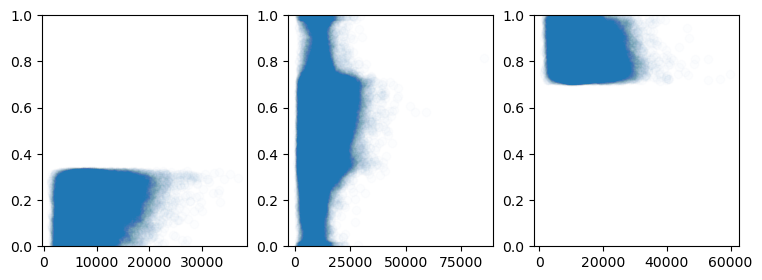

In [15]:
fig, ax = plt.subplots(1,3, figsize=(9,3))
for i, phase in enumerate(['G1','G1S','G2']):
    tmp = sc_stats[sc_stats.GMM_cc_label == phase]
    ax[i].scatter(tmp.nu_area, tmp.pseudotime, alpha = 0.01)
    ax[i].set_ylim(0,1)

In [16]:
from utils.helpers_hierarchy import factorize_into_quantiles
pc_cells, quantiles, df_trans_tmp = factorize_into_quantiles(df_trans, 'PC1', 7)
df_trans_tmp[['PC1', 'PC4', 'PC2','nu_area', 'pseudotime','groups']].corr()

,PC1,PC4,PC2,nu_area,pseudotime,groups
PC1,1.000000,-0.000168,-0.000121,0.333990,0.197563,0.926618
PC4,-0.000168,1.000000,-0.000286,0.231617,0.101559,0.020723
PC2,-0.000121,-0.000286,1.000000,0.011291,0.004331,-0.000858
nu_area,0.333990,0.231617,0.011291,1.000000,0.441108,0.318045
pseudotime,0.197563,0.101559,0.004331,0.441108,1.000000,0.206546
groups,0.926618,0.020723,-0.000858,0.318045,0.206546,1.000000


In [17]:
from sklearn.linear_model import LinearRegression
cols = ['lognu']
cols = [f'PC{n}' for n in range(1,7,1)]
tmp = sc_stats.dropna()#[sc_stats.GMM_cc_label == 'G2'].dropna()
#tmp = sc_stats[sc_stats.pseudotime > 0.4]
model = LinearRegression().fit(tmp[cols], tmp.pseudotime)
r_squared = model.score(tmp[cols], tmp.pseudotime)
print(r_squared)

0.11710599601106564


In [18]:
sc_stats['Protein_nu_mean'] = sc_stats['Protein_nu_sum']/sc_stats['nu_area']
sc_stats['Protein_cyt_mean'] = (sc_stats['Protein_cell_sum']- sc_stats['Protein_nu_sum'])/(sc_stats['cell_area']- sc_stats['nu_area'])
sc_stats['Protein_cell_mean'] = sc_stats['Protein_cell_sum']/sc_stats['cell_area']
sc_stats['cell_nu_ratio'] = sc_stats['cell_area']/sc_stats['nu_area']
if 'PathwayGroup' not in sc_stats.columns:
    sc_stats = sc_stats.merge(mappings, left_on='ab_id',  right_on='Antibody id', how='left')
sc_stats['pseudotime_bin'] = pd.qcut(sc_stats['pseudotime'], 10, labels=False)
sc_stats['lognu'] = np.log(sc_stats['nu_area'])
sc_stats[['pseudotime','pseudotime_bin', 'nu_area','lognu','PC1','PC3','PC4']].corr()

,pseudotime,pseudotime_bin,nu_area,lognu,PC1,PC3,PC4
pseudotime,1.000000,0.995044,0.405940,0.424214,0.206416,-0.258330,0.108370
pseudotime_bin,0.995044,1.000000,0.405306,0.423277,0.205660,-0.257254,0.108708
nu_area,0.405940,0.405306,1.000000,0.947350,0.331412,-0.456708,0.225505
lognu,0.424214,0.423277,0.947350,1.000000,0.338538,-0.471129,0.229485
PC1,0.206416,0.205660,0.331412,0.338538,1.000000,-0.013214,0.011763
PC3,-0.258330,-0.257254,-0.456708,-0.471129,-0.013214,1.000000,-0.018832
PC4,0.108370,0.108708,0.225505,0.229485,0.011763,-0.018832,1.000000


In [19]:
sc_stats.columns

Index(['ab_id', 'cell_id', 'cell_area', 'nu_area', 'nu_eccentricity',
       'Protein_cell_sum', 'Protein_nu_sum', 'MT_cell_sum', 'GMNN_nu_sum',
       'CDT1_nu_sum', 'aspect_ratio_nu', 'aspect_ratio_cell', 'coloc_pro_mt',
       'GMNN_nu_mean', 'CDT1_nu_mean', 'pseudotime', 'GMM_cc', 'GMM_cc_label',
       'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8',
       'Protein_nu_mean', 'Protein_cyt_mean', 'Protein_cell_mean',
       'cell_nu_ratio', 'Antibody id', 'ENSG', 'Gene', 'Gene desc',
       'WellPlate', 'well', 'plate', 'compartment', 'variance_comp',
       'gini_comp', 'isKnownCCD', 'CCD_COMP', 'nonccd_comp', 'Pathway',
       'pathways_grouped', 'PathwayGroup', 'Gene_name', 'pseudotime_bin',
       'lognu'],
      dtype='object')

x_train 103490, x_test 25873, Accuracy 0.5041162601940247, 
 GMM_cc
2    12130
0     7344
1     6399
Name: count, dtype: int64


<Axes: >

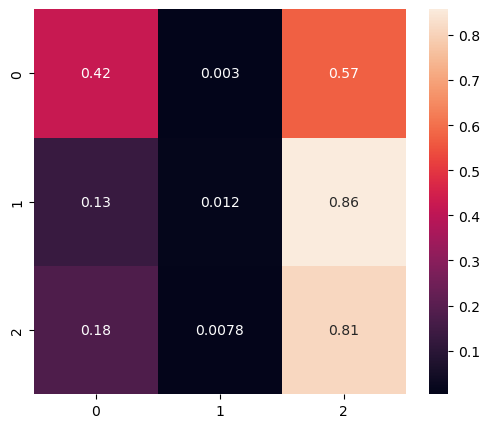

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
# X_train, X_test, y_train, y_test = train_test_split(df[['nu_area','cell_area']], df['GMM_cc'], test_size=0.1, random_state=42, stratify=df['GMM_cc'])

tmp = sc_stats.dropna() #sc_stats[(sc_stats.GMM_cc_label == 'G2') ].dropna() # & (~sc_stats.PC1.isna())]
X_train, X_test, y_train, y_test = train_test_split(tmp[[f'PC{n}' for n in range(1,7,1)]], #tmp[['nu_area', 'cell_area']], #
                                                    tmp['GMM_cc'],#tmp['pseudotime_bin'], 
                                                    test_size=0.20, random_state=99, stratify=tmp['GMM_cc'])


#clf = LinearDiscriminantAnalysis()
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
acc = accuracy_score(y_test, pred)
cm = confusion_matrix(y_test, pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
labels = set(y_test)
# Plot heatmap
plt.figure(figsize=(6, 5))
print(f'x_train {X_train.shape[0]}, x_test {y_test.shape[0]}, Accuracy {acc}, \n {y_test.value_counts()}')
sns.heatmap(cm, annot=True,  xticklabels=labels, yticklabels=labels)

In [21]:
from scipy.stats import spearmanr, pearsonr
#tmp = sc_stats.dropna()
#spearmanr(tmp.pseudotime, tmp.PC3)
results = []
for (pg, gene), tmp_ in tmp.groupby(['PathwayGroup','Gene']):
    line = [pg, gene]
    for p in ['Protein_cell_mean', 'Protein_nu_mean', 'Protein_cyt_mean']:
        for pc in ['PC4','PC1']: #['PC4','PC10']:#['PC1','PC2','PC3','PC4','PC5','PC6']:
            spearmanr_ = spearmanr(tmp_[p], tmp_[pc])
            line.append(spearmanr_[0])
            line.append(spearmanr_[1])
    spearmanr_ = spearmanr(tmp_.Protein_cell_mean, tmp_.PC1)
    results.append(line)
pd.DataFrame(results).head()#, columns=['PathwayGroup','Gene','Protein_cell_mean','Protein_nu_mean','Protein_cyt_mean'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Amino-Acid-Metabolism,AASS,-0.094897,9.588444e-02,-0.116581,4.056128e-02,0.075240,0.187132,0.161710,0.004374,-0.166653,3.301313e-03,-0.218015,1.118212e-04
1,Amino-Acid-Metabolism,ABAT,-0.041195,2.608011e-01,-0.141407,1.053745e-04,0.004623,0.899628,-0.010297,0.778741,-0.065645,7.295921e-02,-0.125275,5.997858e-04
2,Amino-Acid-Metabolism,ALDH3A1,-0.198225,4.455694e-09,-0.189843,1.982005e-08,-0.091708,0.007087,-0.007492,0.826239,-0.199724,3.387708e-09,-0.187001,3.239036e-08
3,Amino-Acid-Metabolism,ALDH6A1,-0.011699,8.449222e-01,-0.114281,5.525509e-02,0.033979,0.569876,-0.157499,0.008057,-0.019680,7.421140e-01,-0.080595,1.771444e-01
4,Amino-Acid-Metabolism,ALDH7A1,0.021396,3.808069e-01,-0.050870,3.708384e-02,-0.001620,0.947103,0.027610,0.258027,0.014501,5.525505e-01,-0.045533,6.206115e-02


In [22]:
pc = 'PC4'
#tmp['group'] = tmp[pc].apply(lambda x: 'b0' if x in [0, 1] else 'b2' if x in [5, 6] else 'other')

# lets compared elongated cells that are large vs small
tmp['group'] = np.where(tmp.PC1.isin([5,6]) & tmp.PC4.isin([0,1]), 'b0', 
                        np.where(tmp.PC1.isin([5, 6]) & tmp.PC4.isin([5,6]), 'b2', 'other'))

agg_df = tmp[tmp.group != 'other'].groupby(['PathwayGroup','Pathway', 'group', 'Gene']).agg({
    'Protein_cell_mean': 'mean',
    'Protein_nu_mean': 'mean',
    'Protein_cyt_mean': 'mean'
}).reset_index()

# Melt the DataFrame for boxplot-friendly format
melted_df = agg_df.melt(id_vars=['PathwayGroup','Pathway', 'group','Gene'], 
                         var_name='Protein Type', 
                         value_name='Mean Expression')

# Create separate plots for each PathwayGroup
#melted_df = melted_df[melted_df['PathwayGroup'] == 'Lipid-Metabolism']
pathways = melted_df['Pathway'].unique()
num_pathways = len(pathways)

'''
fig, axes = plt.subplots(num_pathways, 1, figsize=(5, 3 * num_pathways), sharex=True)

for i, pathway in enumerate(pathways):
    ax = axes[i] if num_pathways > 1 else axes
    subset = melted_df[melted_df['Pathway'] == pathway]
    sns.boxplot(data=subset, x='group', y='Mean Expression', hue='Protein Type', ax=ax)
    ax.set_title(f'Pathway: {pathway}')
    ax.set_xlabel(f'{pc} Group')
    ax.set_ylabel('Mean Protein Expression')
    ax.legend(title='Protein Type')
    ax.set_yscale('log')
plt.tight_layout()
plt.show()
'''

/tmp/ipykernel_478834/156415068.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['group'] = np.where(tmp.PC1.isin([5,6]) & tmp.PC4.isin([0,1]), 'b0',


"\nfig, axes = plt.subplots(num_pathways, 1, figsize=(5, 3 * num_pathways), sharex=True)\n\nfor i, pathway in enumerate(pathways):\n    ax = axes[i] if num_pathways > 1 else axes\n    subset = melted_df[melted_df['Pathway'] == pathway]\n    sns.boxplot(data=subset, x='group', y='Mean Expression', hue='Protein Type', ax=ax)\n    ax.set_title(f'Pathway: {pathway}')\n    ax.set_xlabel(f'{pc} Group')\n    ax.set_ylabel('Mean Protein Expression')\n    ax.legend(title='Protein Type')\n    ax.set_yscale('log')\nplt.tight_layout()\nplt.show()\n"

In [23]:
from shapemodes.s3_calculate_shapemodes_all import load_fft
fft_dir = f"{project_dir}/fftcoefs/{cfg.ALIGNMENT}"
fft_path = os.path.join(fft_dir, f"fftcoefs_{cfg.N_COEFS}.txt")
lines = load_fft(cfg, project_dir)

df = pd.DataFrame(lines).transpose()
df = df.applymap(lambda s: complex(s.replace("i", "j")))

Loading 315033 lines


/tmp/ipykernel_478834/563996490.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda s: complex(s.replace("i", "j")))


In [24]:
tmp = sc_stats[sc_stats.GMM_cc_label == 'G2'].dropna().drop_duplicates(subset=['ab_id','cell_id','Pathway'])
#tmp = sc_stats.dropna().drop_duplicates(subset=['ab_id','cell_id','Pathway'])
tmp['filename'] = '/data/2Dshapespace/S-BIAD34/cell_masks/' + tmp['ab_id'] + '/' + tmp['cell_id'] + '.npy'
tmp = tmp[tmp.filename.isin(df.index)]
tmp['group'] = np.where(tmp.PC1.isin([4,5,6]) & tmp.PC4.isin([0,1,2]), 'b0', 
                        np.where(tmp.PC1.isin([4,5,6]) & tmp.PC4.isin([4,5,6]), 'b2', 'b1'))
#tmp['group'] = np.where(tmp.PC4.isin([0,1]), 'b0', 
#                        np.where(tmp.PC4.isin([5,6]), 'b2', 'b1'))

df_trans['filename'] = '/data/2Dshapespace/S-BIAD34/cell_masks/' + df_trans['ab_id'] + '/' + df_trans['cell_id'] + '.npy'
tmp.groupby('group').agg({#'Protein_cell_mean':'mean', 
                          #'Protein_nu_mean':'mean', 
                          #'Protein_cyt_mean':'mean', 
                          'cell_nu_ratio':'mean', 
                          'nu_area':'mean', 
                          'cell_area':'mean', 
                          'aspect_ratio_nu':'mean',
                          'aspect_ratio_cell':'mean',
                          'nu_eccentricity':'mean',
                          'pseudotime':'count'}) 

,cell_nu_ratio,nu_area,cell_area,aspect_ratio_nu,aspect_ratio_cell,nu_eccentricity,pseudotime
group,,,,,,,
b0,4.663517,12908.220577,59885.146177,0.651172,0.397233,0.740431,5336
b1,4.344611,12042.946940,52455.355144,0.693496,0.578478,0.699624,21014
b2,5.245876,14798.808258,76857.281411,0.720233,0.645241,0.674733,5643


Text(0, 0.5, 'PC4')

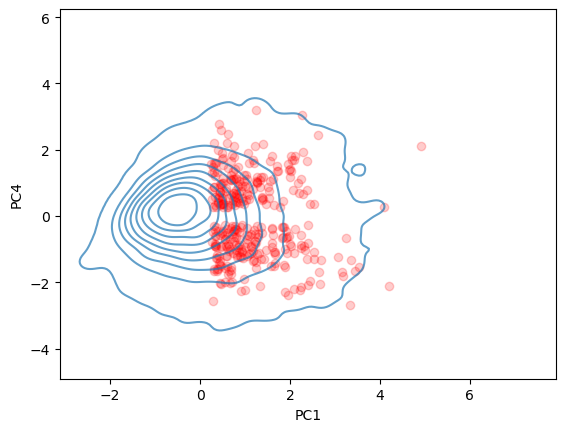

In [25]:
df_trans['PC1_zscore'] = (df_trans.PC1 - df_trans.PC1.mean()) / df_trans.PC1.std()
df_trans['PC4_zscore'] = (df_trans.PC4 - df_trans.PC4.mean()) / df_trans.PC4.std()

toplot = df_trans.sample(20000)
#plt.scatter(toplot.PC1_zscore, toplot.PC4_zscore, c = 'gray', alpha = 0.1)
sns.kdeplot(x = toplot.PC1_zscore, y = toplot.PC4_zscore,  fill=False, alpha=0.7, thresh=0.01)
plt.scatter(toplot[toplot.filename.isin(tmp[tmp.group=='b0'].filename)].PC1_zscore, toplot[toplot.filename.isin(tmp[tmp.group=='b0'].filename)].PC4_zscore, c = 'red', alpha = 0.2)
plt.scatter(toplot[toplot.filename.isin(tmp[tmp.group=='b2'].filename)].PC1_zscore, toplot[toplot.filename.isin(tmp[tmp.group=='b2'].filename)].PC4_zscore, c = 'red', alpha = 0.2)
plt.xlabel('PC1')
plt.ylabel('PC4')

In [26]:
#sc_stats.dropna().drop_duplicates(subset=['ab_id','cell_id','Pathway'])

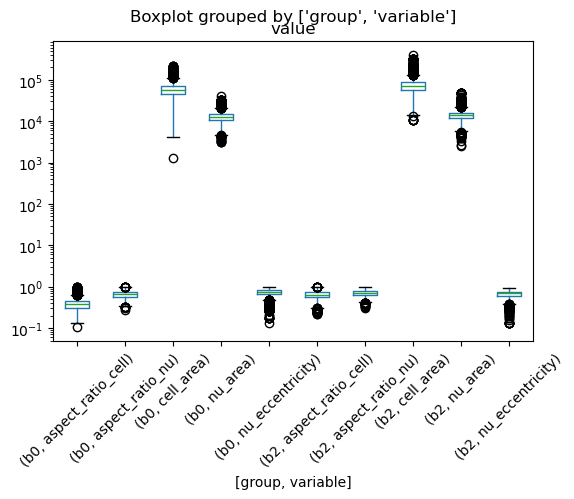

In [27]:
#plt.boxplot([tmp[tmp.group=='b0'].nu_area, tmp[tmp.group=='b2'].nu_area])
#plt.boxplot([tmp[tmp.group=='b0'].cell_area, tmp[tmp.group=='b2'].cell_area])
#plt.yscale('log')
tmp[tmp.group!= 'b1'].melt(id_vars="group", value_vars=["nu_area", "cell_area",'nu_eccentricity','aspect_ratio_nu','aspect_ratio_cell']).boxplot(
    by=["group", "variable"], column="value", grid=False, rot=45, figsize=(6, 4))
plt.yscale('log')

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/_base.py:

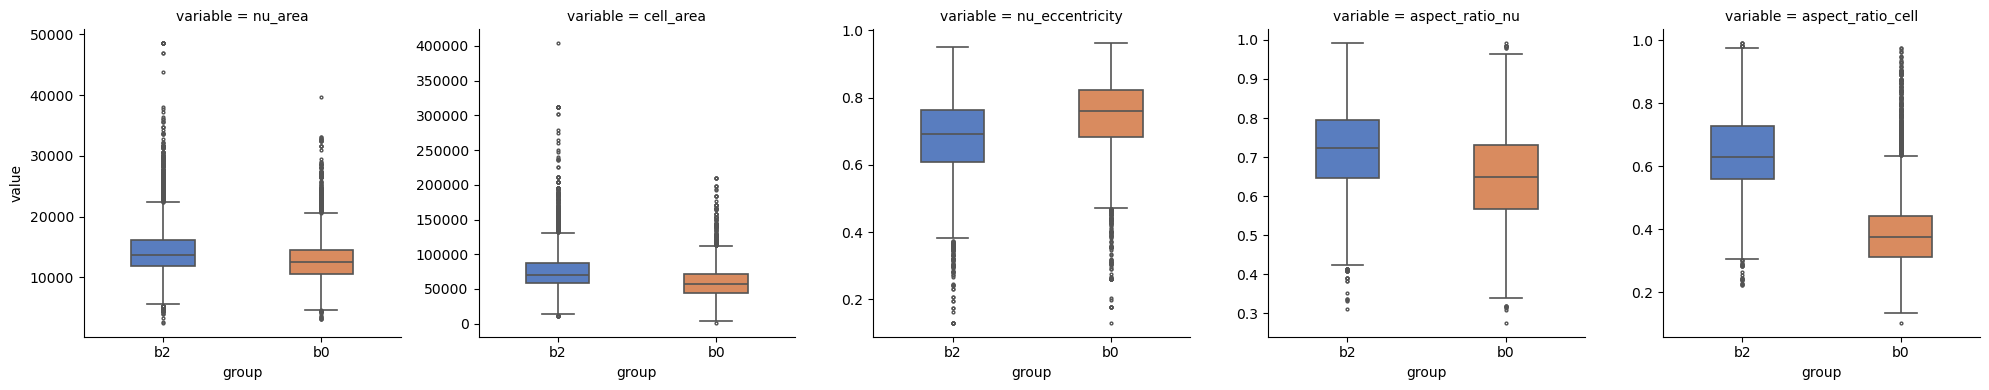

In [28]:
# Prettier plot
df_melted = tmp[tmp['group'] != 'b1'].melt(
    id_vars="group", 
    value_vars=["nu_area", "cell_area", 'nu_eccentricity', 'aspect_ratio_nu', 'aspect_ratio_cell']
)

g = sns.FacetGrid(df_melted, col="variable", col_wrap=5, sharey=False, height=4, aspect=1)
g.map_dataframe(sns.boxplot, x="group", y="value", palette="muted", width=0.4, linewidth=1.2, fliersize=2)

if False:#for ax in g.axes.flat:
    ax.set_yscale("log")  # Log scale
    ax.set_xlabel("")  # Remove x-axis labels
    ax.tick_params(axis='x', rotation=45, labelsize=10)  # Rotate x labels
    ax.set_ylabel("Value (log scale)", fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()


In [29]:
tmp.columns


Index(['ab_id', 'cell_id', 'cell_area', 'nu_area', 'nu_eccentricity',
       'Protein_cell_sum', 'Protein_nu_sum', 'MT_cell_sum', 'GMNN_nu_sum',
       'CDT1_nu_sum', 'aspect_ratio_nu', 'aspect_ratio_cell', 'coloc_pro_mt',
       'GMNN_nu_mean', 'CDT1_nu_mean', 'pseudotime', 'GMM_cc', 'GMM_cc_label',
       'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8',
       'Protein_nu_mean', 'Protein_cyt_mean', 'Protein_cell_mean',
       'cell_nu_ratio', 'Antibody id', 'ENSG', 'Gene', 'Gene desc',
       'WellPlate', 'well', 'plate', 'compartment', 'variance_comp',
       'gini_comp', 'isKnownCCD', 'CCD_COMP', 'nonccd_comp', 'Pathway',
       'pathways_grouped', 'PathwayGroup', 'Gene_name', 'pseudotime_bin',
       'lognu', 'filename', 'group'],
      dtype='object')

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


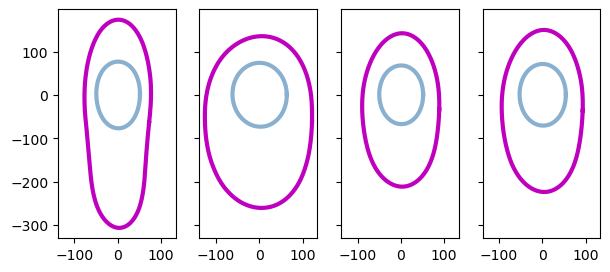

In [30]:
from coefficients.coefs import inverse_fft
def plot_avg_shape(fcoef, ax=None):
    n = 128
    fcoef_c = fcoef[0 : n * 2]
    fcoef_n = fcoef[n * 2 :]
    ix_n, iy_n = inverse_fft(fcoef_n[0 : n], fcoef_n[n :])
    ix_c, iy_c = inverse_fft(fcoef_c[0 : n], fcoef_c[n :])
    if ax:
        ax.plot(ix_n, iy_n, c="#8ab0cf", linewidth=3)
        ax.plot(ix_c, iy_c, c="m", linewidth=3)
        ax.axis('scaled')
    else:
        plt.plot(ix_n, iy_n, c="#8ab0cf", linewidth=3)
        plt.plot(ix_c, iy_c, c="m", linewidth=3)
        plt.axis('scaled')

fig, ax = plt.subplots(1,4, figsize=(7,3), sharex=True, sharey=True)
plot_avg_shape(df[df.index.isin(tmp[tmp.group=='b0'].filename)].mean().values, ax=ax[0])
plot_avg_shape(df[df.index.isin(tmp[tmp.group=='b2'].filename)].mean().values, ax=ax[1])
plot_avg_shape(df.mean().values, ax=ax[2])
plot_avg_shape(df[df.index.isin(tmp.filename)].mean().values, ax=ax[3])

In [31]:
from scipy import stats
def compute_ttest(df):
    results = {}
    for value in ['Protein_cell_mean', 'Protein_nu_mean', 'Protein_cyt_mean']:
        b2_values = df[df['group'] == 'b2'][value]
        b0_values = df[df['group'] == 'b0'][value]
        if len(b2_values) > 1 and len(b0_values) > 1:
            #pval = stats.ttest_ind(b2_values, b0_values, equal_var=False).pvalue
            pval = stats.mannwhitneyu(b0_values, b2_values, alternative='two-sided')[1]
        else:
            pval = float('nan')
        results['ttest_pval_' + value.split('_')[1]] = pval 
        results['FC_' + value.split('_')[1]] = b2_values.mean()/b0_values.mean()               
    return pd.Series(results)

agg_df = tmp[tmp.group != 'b1'].groupby(['PathwayGroup','Pathway', 'group', 'Gene']).agg({
    'Protein_cell_mean': 'mean',
    'Protein_nu_mean': 'mean',
    'Protein_cyt_mean': 'mean',
}).reset_index()
#agg_df = tmp[tmp.group != 'b1'].groupby(['PathwayGroup', 'Pathway', 'Gene']).apply(compute_ttest).reset_index()

# Melt the DataFrame for boxplot-friendly format
melted_df = agg_df.melt(id_vars=['PathwayGroup','Pathway', 'group','Gene'], 
                         var_name='Protein Type', 
                         value_name='Mean Expression')

fc_df = melted_df.groupby(['PathwayGroup', 'Pathway','Protein Type','Gene'], as_index=False).agg(foldchange=('Mean Expression', lambda x: x[melted_df['group'] == 'b2'].mean() / x[melted_df['group'] == 'b0'].mean()), 
                                 sample_count=('Gene', 'nunique')).sort_values('foldchange')

#fc_df = fc_df.groupby(['PathwayGroup', 'Pathway','Protein Type'], as_index=False).agg(foldchange=('foldchange', 'mean'), 
#                                 sample_count=('sample_count', 'sum'))
fc_df.dropna().sort_values('foldchange')

,PathwayGroup,Pathway,Protein Type,Gene,foldchange,sample_count
714,Lipid-Metabolism,Cholesterol-metabolism,Protein_cyt_mean,SC5D,0.360282,1
709,Lipid-Metabolism,Cholesterol-biosynthesis-2,Protein_cyt_mean,SC5D,0.360282,1
1372,Transport,Transport-reactions,Protein_cyt_mean,SLC25A42,0.485220,1
224,Amino-Acid-Metabolism,Tyrosine-metabolism,Protein_cyt_mean,GPT2,0.516301,1
9,Amino-Acid-Metabolism,"Alanine,-aspartate-and-glutamate-metabolism",Protein_cyt_mean,GPT2,0.516301,1
...,...,...,...,...,...,...
1304,Nucleotide-Metabolism,Pyrimidine-metabolism,Protein_nu_mean,PKM,2.002529,1
359,Carbohydrate-Metabolism,Glycolysis---Gluconeogenesis,Protein_nu_mean,PKM,2.002529,1
455,Carbohydrate-Metabolism,Pyruvate-metabolism,Protein_nu_mean,PKM,2.002529,1
970,Metabolism-of-cofactors-and-vitamins,Retinol-metabolism,Protein_cell_mean,CYP26B1,2.412458,1


In [32]:
#fc_df.groupby(['PathwayGroup', 'Pathway','Protein Type'], as_index=False).agg({'foldchange':'mean', 'sample_count':'count'}).sort_values('foldchange')
#fc_df[fc_df.Pathway.str.contains('Cholesterol')]
sig_protein = tmp[tmp.group != 'b1'].groupby(['PathwayGroup', 'Pathway', 'Gene']).apply(compute_ttest).reset_index()
sig_protein = sig_protein[(sig_protein.ttest_pval_nu < 0.05)|(sig_protein.ttest_pval_cell < 0.05)|(sig_protein.ttest_pval_cyt < 0.05)]
sig_protein.sort_values('FC_cyt')
#sig_protein.groupby(['PathwayGroup', 'Pathway']).agg({'Gene':'count', 'FC_nu': 'mean', 'FC_cell':'mean', 'FC_cyt':'mean'}).sort_values('Gene', ascending=False)

/tmp/ipykernel_478834/965782608.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sig_protein = tmp[tmp.group != 'b1'].groupby(['PathwayGroup', 'Pathway', 'Gene']).apply(compute_ttest).reset_index()


,PathwayGroup,Pathway,Gene,ttest_pval_cell,FC_cell,ttest_pval_nu,FC_nu,ttest_pval_cyt,FC_cyt
4,Amino-Acid-Metabolism,"Alanine,-aspartate-and-glutamate-metabolism",GPT2,0.007699,0.559326,0.059663,0.715855,0.003185,0.516301
74,Amino-Acid-Metabolism,Tyrosine-metabolism,GPT2,0.007699,0.559326,0.059663,0.715855,0.003185,0.516301
357,Miscellanous,Isolated,NKTR,0.016434,0.600048,0.022902,0.710136,0.016434,0.553176
356,Miscellanous,Isolated,NCOA1,0.071680,0.639087,0.387829,0.758777,0.040572,0.580495
174,Energy-Metabolism,Tricarboxylic-acid-cycle-and-glyoxylate-dicarb...,SDHA,0.097961,0.671707,0.245278,0.798889,0.031734,0.625628
112,Carbohydrate-Metabolism,Glycolysis---Gluconeogenesis,GAPDH,0.018919,0.658641,0.224185,0.814828,0.015059,0.630072
129,Carbohydrate-Metabolism,Inositol-phosphate-metabolism,PTPRQ,0.055556,0.699057,0.841270,1.024957,0.031746,0.632539
364,Miscellanous,Isolated,PCMT1,0.059274,0.686460,0.851815,0.899123,0.019980,0.638806
371,Miscellanous,Isolated,RFWD3,0.069432,0.753409,0.479084,0.914549,0.028898,0.696082
67,Amino-Acid-Metabolism,"Phenylalanine,-tyrosine-and-tryptophan-biosynt...",TYW3,0.049098,0.728593,0.550985,0.878204,0.027366,0.703998


<Axes: xlabel='Protein Type', ylabel='PathwayGroup-Pathway'>

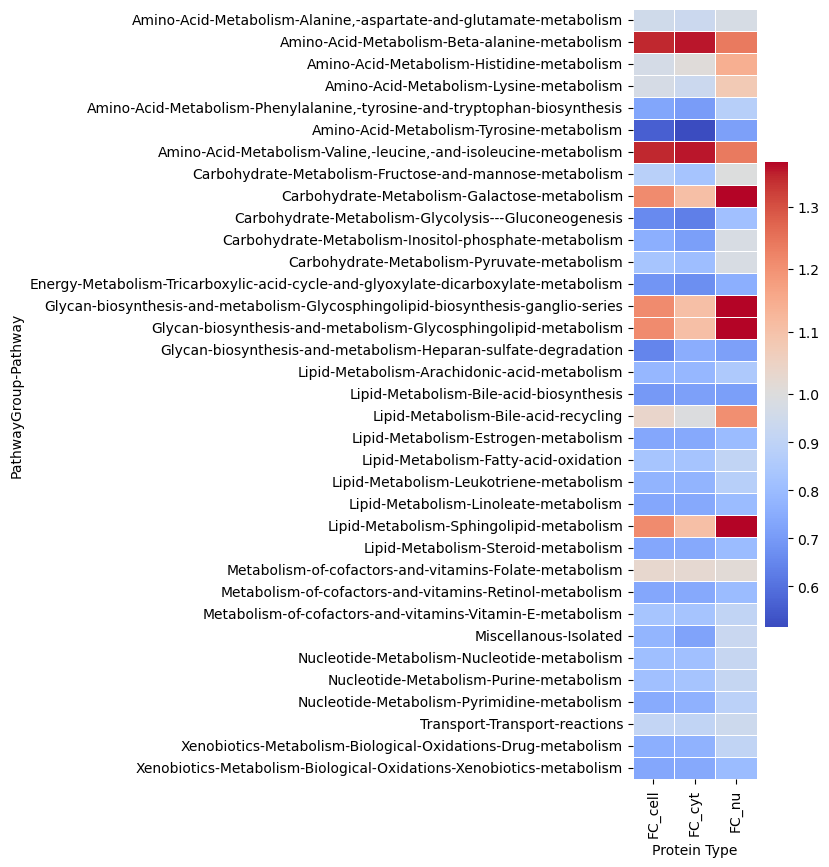

In [34]:
#fc_df[(fc_df.sample_count > 5) & ~fc_df.foldchange.isna()].sort_values('foldchange')
#melted_df

from matplotlib.colors import TwoSlopeNorm
plt.figure(figsize=(2, 10))
toplot = sig_protein.groupby(['PathwayGroup', 'Pathway']).agg({'FC_cell': 'mean', 'FC_nu':'mean', 'FC_cyt':'mean'}).reset_index()
toplot = toplot.melt(id_vars=['PathwayGroup','Pathway'], 
                         var_name='Protein Type', 
                         value_name='MeanFC')

norm = TwoSlopeNorm(vmin=toplot.MeanFC.min(), vcenter=1, vmax=toplot.MeanFC.max())

#toplot.melt(id_vars=['PathwayGroup', 'Pathway'], value_vars=['foldchange'])
heatmap_data = toplot.pivot(index=['PathwayGroup','Pathway'], columns='Protein Type', values='MeanFC')
heatmap_data.sort_index(level=0, ascending=True, inplace=True)
sns.heatmap(heatmap_data, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5, norm=norm)


In [35]:
toplot = sig_protein.groupby(['PathwayGroup', 'Pathway']).agg({'FC_cell': 'mean', 'FC_nu':'mean', 'FC_cyt':'mean'}).reset_index()
toplot = toplot.melt(id_vars=['PathwayGroup','Pathway'], var_name='Protein Type', value_name='MeanFC')
toplot

,PathwayGroup,Pathway,Protein Type,MeanFC
0,Amino-Acid-Metabolism,"Alanine,-aspartate-and-glutamate-metabolism",FC_cell,0.952879
1,Amino-Acid-Metabolism,Beta-alanine-metabolism,FC_cell,1.346432
2,Amino-Acid-Metabolism,Histidine-metabolism,FC_cell,0.968718
3,Amino-Acid-Metabolism,Lysine-metabolism,FC_cell,0.971976
4,Amino-Acid-Metabolism,"Phenylalanine,-tyrosine-and-tryptophan-biosynt...",FC_cell,0.728593
...,...,...,...,...
100,Nucleotide-Metabolism,Purine-metabolism,FC_cyt,0.826220
101,Nucleotide-Metabolism,Pyrimidine-metabolism,FC_cyt,0.762589
102,Transport,Transport-reactions,FC_cyt,0.907951
103,Xenobiotics-Metabolism-Biological-Oxidations,Drug-metabolism,FC_cyt,0.768379


In [36]:
'''
fig, ax = plt.subplots(figsize=(2, 3))
cmaps = ['Reds', 'copper', 'Purples', 'Greens','Blues', 'Oranges']
labels = list(fc_df.PathwayGroup.unique())
len(labels)
beg, end = 0, 1
for i, cmap in enumerate(cmaps):
    #mask = heatmap_data[heatmap_data.PathwayGroup == labels[i]]
    group_data = fc_df[fc_df['PathwayGroup'] == labels[i]].pivot(index='Pathway', columns='Protein Type', values='foldchange')
    sns.heatmap(group_data, annot=False, cmap=cmap, fmt=".2f", linewidths=0.5, ax=ax, cbar=False)
    plt.title(labels[i])
    ax.text(1.01, (beg + end) / 2, '\n'.join(labels[i].split()), ha='left', va='center', transform=ax.get_yaxis_transform())
    beg = end
    end = beg + group_data.shape[0]
'''
#from matplotlib.colors import Normalize
#norm = Normalize(vmin=fc_df.foldchange.min(), vmax=fc_df.foldchange.max(), clip=True)
toplot = fc_df[(fc_df['Protein Type'] == 'Protein_cell_mean') & (fc_df.sample_count > 5) & ~fc_df.foldchange.isna()]
norm = TwoSlopeNorm(vmin=toplot.foldchange.min(), vcenter=1, vmax=toplot.foldchange.max())
plt.figure(figsize=(1, 8))
# Pivot table for heatmap format
heatmap_data = toplot.pivot(index=['PathwayGroup','Pathway'], columns='Protein Type', values='foldchange')
heatmap_data.sort_index(level=0, ascending=True, inplace=True)
sns.heatmap(heatmap_data, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5, norm=norm)
plt.title(f'Fold Change in Protein Expression between elongated round vs elongated large shapes in G2 cells')

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 100x800 with 0 Axes>

In [ ]:
sc_stats[sc_stats.PC1.isin([5,6]) & sc_stats.PC4.isin([5,6])].groupby('GMM_cc_label').agg({'pseudotime':'mean', 'cell_id':'count','nu_area':'mean','cell_area':'mean'})
#tmp.group.value_counts()

,pseudotime,cell_id,nu_area,cell_area
GMM_cc_label,,,,
G1,0.173519,2568,11177.699377,60766.405374
G1S,0.536003,9849,15046.885268,86025.017362
G2,0.856132,6770,15834.859675,87260.652733


In [37]:
#sc_stats[sc_stats.PC1.isin([0,1]) & sc_stats.PC4.isin([5,6])].shape
#fc_df.foldchange.describe()
#tmp.boxplot(x='group', y='nu_area',rot=45, fontsize=12, figsize=(8, 10))  
#tmp[tmp.group=='b2'].nu_area.describe(), tmp[tmp.group=='b0'].nu_area.describe()
metabolism_term = 'Glycosphingolipid'#'Pyrimi' #'Glycosphingolipid-metabolism'#"Glycerolipid"#"Oxidativ"#'Sphi'#'Valine,-leucine,-and-isoleucine-metabolism'#'Eicosanoid-metabolism'
#"Cholesterol-biosynthesis-2"#"Biopterin-metabolism"
fc_df[fc_df.Pathway.str.contains(metabolism_term)]

,PathwayGroup,Pathway,Protein Type,Gene,foldchange,sample_count
535,Glycan-biosynthesis-and-metabolism,Glycosphingolipid-metabolism,Protein_cell_mean,OGT,0.770450,1
539,Glycan-biosynthesis-and-metabolism,Glycosphingolipid-metabolism,Protein_cyt_mean,OGT,0.782738,1
543,Glycan-biosynthesis-and-metabolism,Glycosphingolipid-metabolism,Protein_nu_mean,OGT,0.795706,1
541,Glycan-biosynthesis-and-metabolism,Glycosphingolipid-metabolism,Protein_cyt_mean,UGT8,0.814512,1
537,Glycan-biosynthesis-and-metabolism,Glycosphingolipid-metabolism,Protein_cell_mean,UGT8,0.861833,1
531,Glycan-biosynthesis-and-metabolism,Glycosphingolipid-biosynthesis-lacto-and-neola...,Protein_cell_mean,GCNT2,0.910639,1
532,Glycan-biosynthesis-and-metabolism,Glycosphingolipid-biosynthesis-lacto-and-neola...,Protein_cyt_mean,GCNT2,0.919263,1
545,Glycan-biosynthesis-and-metabolism,Glycosphingolipid-metabolism,Protein_nu_mean,UGT8,0.983185,1
538,Glycan-biosynthesis-and-metabolism,Glycosphingolipid-metabolism,Protein_cyt_mean,MGAT5B,0.992415,1
534,Glycan-biosynthesis-and-metabolism,Glycosphingolipid-metabolism,Protein_cell_mean,MGAT5B,1.027525,1


In [ ]:
#sc_stats[~sc_stats.PathwayGroup.isna()]

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  pos

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TMPPE_b2 vs. TMPPE_b0: Custom statistical test, P_val:2.239e-03
MGAT5B_b2 vs. MGAT5B_b0: Custom statistical test, P_val:7.211e-01
OGT_b2 vs. OGT_b0: Custom statistical test, P_val:1.348e-01
GCNT2_b2 vs. GCNT2_b0: Custom statistical test, P_val:9.740e-01
UGT8_b2 vs. UGT8_b0: Custom statistical test, P_val:9.688e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

TMPPE_b2 vs. TMPPE_b0: Custom statistical test, P_val:6.450e-01
MGAT5B_b2 vs. MGAT5B_b0: Custom statistical test, P_val:1.000e+00
OGT_b2 vs. OGT_b0: Custom statistical test, P_val:6.749e-02
GCNT2_b2 vs. GCNT2_b0: Custom statistical test, P_val:4.921e-01
UGT8_b2 vs. UGT8_b0: Custom statistical test, 

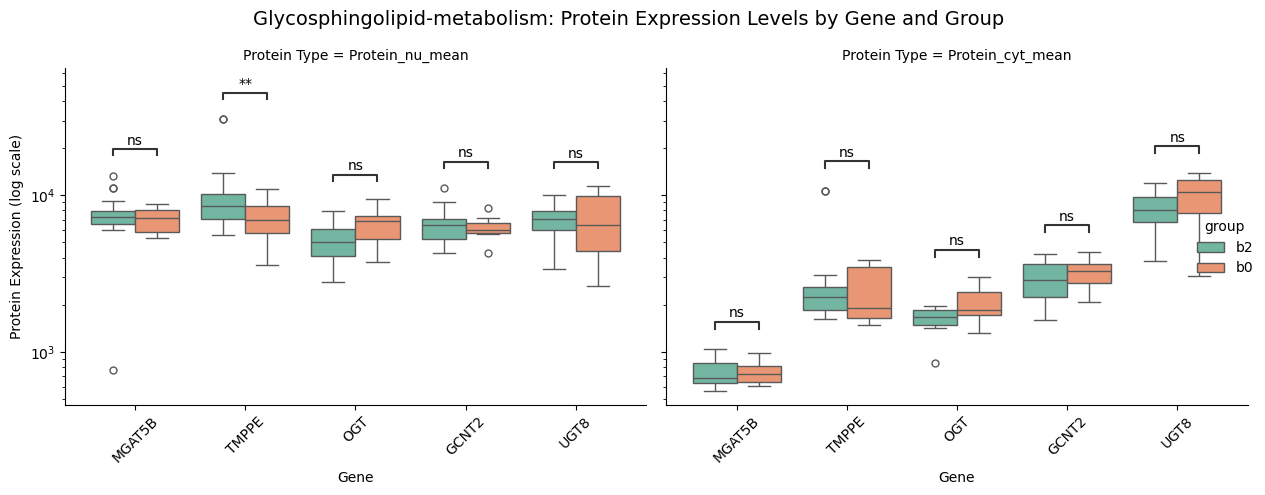

In [38]:
# ! pip install statannotations

import scipy.stats as stats
from statannotations.Annotator import Annotator
df_melted = tmp[~tmp.Pathway.isna() & tmp.Pathway.str.contains(metabolism_term) & tmp.group.isin(['b0','b2'])].melt(id_vars=["Gene", "group"], value_vars=["Protein_nu_mean", "Protein_cyt_mean"], 
                      var_name="Protein Type", value_name="Value")

# Define the pairs for significance testing (b0 vs b2 for each Gene)
#pairs = [(gene, gene) for gene in df_melted["Gene"].unique()]

# Create a FacetGrid with separate plots for each Protein Type
g = sns.catplot(
    x="Gene", y="Value", hue="group", col="Protein Type",
    data=df_melted, kind="box", palette="Set2",
    height=5, aspect=1.2
)

g.set(yscale="log")
# Iterate over each subplot (one per Protein Type)
for ax, protein_type in zip(g.axes.flat, df_melted["Protein Type"].unique()):
    sub_df = df_melted[df_melted["Protein Type"] == protein_type]

    # Define valid pairs and perform statistical tests
    valid_pairs = []
    p_values = []
    
    for gene in sub_df["Gene"].unique():
        group_b0 = sub_df[(sub_df["Gene"] == gene) & (sub_df["group"] == "b0")]["Value"]
        group_b2 = sub_df[(sub_df["Gene"] == gene) & (sub_df["group"] == "b2")]["Value"]

        if len(group_b0) > 1 and len(group_b2) > 1:  # Ensure enough samples
            #stat, p = stats.ttest_ind(group_b0, group_b2, equal_var=False)  # Welch’s t-test
            stat, p = stats.mannwhitneyu(group_b0, group_b2, alternative='two-sided')
            #stat, p = stats.permutation_test((group_b0, group_b2), statistic='mean', permutation_type='independent')
            valid_pairs.append((gene, 'b0','b2'))  # Use Gene names as x-axis category pairs
            p_values.append(p)
            
    # Annotate significance only if valid pairs exist
    if valid_pairs:
        annotator = Annotator(ax, pairs=[((gene, "b0"), (gene, "b2")) for gene, _, _ in valid_pairs], 
                              data=sub_df, x="Gene", y="Value", hue="group")
        annotator.configure(test=None, text_format="star")#, loc="outside")
        #annotator.configure(test='Mann-Whitney', text_format="star", loc="outside")
        #annotator.apply_and_annotate()
        annotator.set_pvalues(p_values).annotate()

g.set_xticklabels(rotation=45)

# Set labels and titles
g.set_axis_labels("Gene", "Protein Expression (log scale)")
g.fig.suptitle(f"{tmp[tmp.Pathway.str.contains(metabolism_term)].Pathway.unique()[0]}: Protein Expression Levels by Gene and Group", fontsize=14)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
#tmp[tmp.Pathway.str.contains(metabolism_term)].groupby('Gene').value_counts(['group'])

In [39]:
for g, tmp_ in tmp[~tmp.Pathway.isna() & tmp.Pathway.str.contains(metabolism_term)].groupby('Gene_name'):
    if tmp.group.str.contains('b0').any() and tmp.group.str.contains('b2').any():
        print(g, tmp_.groupby('group').agg({'Protein_cyt_mean':'mean','Gene':'count'}))#, tmp_.groupby('group').agg({'Protein_cell_mean':'mean', 'Protein_nu_mean':'mean', 'Protein_cyt_mean':'mean', 'cell_nu_ratio':'mean', 'pseudotime':'count'}))

GCNT2        Protein_cyt_mean  Gene
group                        
b0          3208.726013     7
b1          2805.079189    39
b2          2949.661926    16
MGAT5B        Protein_cyt_mean  Gene
group                        
b0           750.820261     6
b1           890.768016    37
b2           745.125244    18
OGT        Protein_cyt_mean  Gene
group                        
b0          2035.546497    13
b1          2420.662797    59
b2          1593.300385     7
TMPPE        Protein_cyt_mean  Gene
group                        
b0          2406.557029    28
b1          2610.891229   156
b2          2664.848595    38
UGT8        Protein_cyt_mean  Gene
group                        
b0          9710.045359     7
b1          8746.085972    57
b2          7908.943810    29


In [40]:
from imageio import imread
b0_cells = tmp[(tmp.Gene_name == 'TMPPE') & (tmp.group.isin(['b0']))].filename.unique()
b2_cells = tmp[(tmp.Gene_name == 'TMPPE') & (tmp.group.isin(['b2']))].filename.unique()
#b0_cells, b2_cells
images = [imread(f.replace('.npy','_protein.png')) for f in list(b0_cells) + list(b2_cells)]
global_max = max(np.percentile(img, 99) for img in images) #* 0.9

/tmp/ipykernel_478834/1089574730.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imread(f.replace('.npy','_protein.png')) for f in list(b0_cells) + list(b2_cells)]


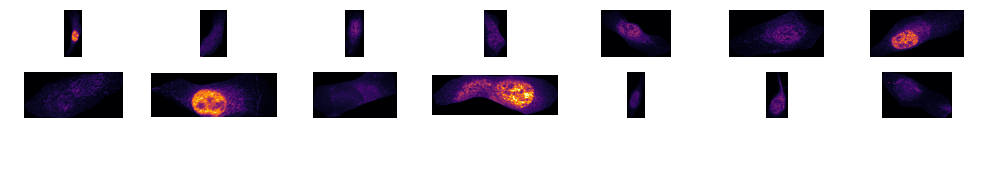

In [ ]:
from organelle_heatmap_helpers import plot_image_collage
plot_image_collage([f.replace('.npy','_protein.png') for f in b0_cells][:14], n_cols=7, figsize=(10,2), globalvmax=global_max)

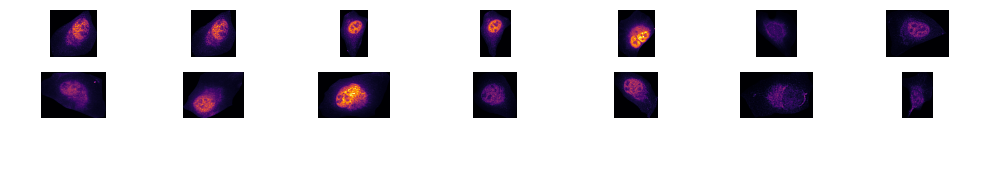

In [41]:
plot_image_collage([f.replace('.npy','_protein.png') for f in b2_cells][:14], n_cols=7, figsize=(10,2), globalvmax=global_max)

/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_478834/1620323156.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ax[1].imshow(imread(b0_cells[i].replace('.npy','_protein.png')), origin='lower', cmap='inferno', vmax=global_max)
/tmp/ipykernel_478834/1620323156.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this 

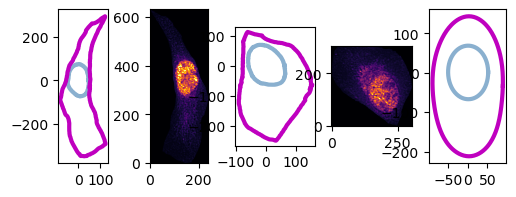

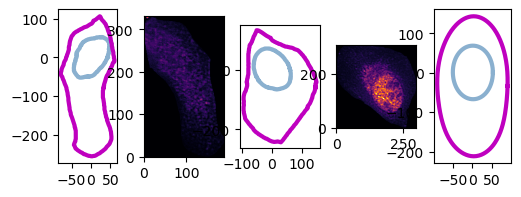

In [42]:
from imageio import imread
for i in range(2):
    fig, ax = plt.subplots(1,5, figsize=(6,2))#, sharex=True, sharey=True)
    plot_avg_shape(df[df.index==b0_cells[i]].mean().values, ax=ax[0])
    ax[1].imshow(imread(b0_cells[i].replace('.npy','_protein.png')), origin='lower', cmap='inferno', vmax=global_max)
    plot_avg_shape(df[df.index==b2_cells[i]].mean().values, ax=ax[2])
    ax[3].imshow(imread(b2_cells[i].replace('.npy','_protein.png')), origin='lower', cmap='inferno', vmax=global_max)
    plot_avg_shape(df.mean().values, ax=ax[4])


/tmp/ipykernel_478834/4135660352.py:66: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imread(f.replace('.npy','_protein.png')) for f in list(b0_cells) + list(b2_cells)]


HPA022120/5977_B06_s5_4.npy /data/2Dshapespace/S-BIAD34/cell_masks/HPA022120/5977_B06_s5_4.npy;137.0778101720939;(227.43534319302236, 333.4851725445582);3.1648143678013305;0.8006792596850182
 /data/2Dshapespace/S-BIAD34/fftcoefs/fft_cell_major_axis_polarized/shift_error_meta_fft128.txt ['/data/2Dshapespace/S-BIAD34/cell_masks/HPA022120/5977_B06_s5_4.npy', '137.0778101720939', '(227.43534319302236, 333.4851725445582)', '3.1648143678013305', '0.8006792596850182'] 137.0778101720939
HPA022120/5977_B06_s5_27.npy /data/2Dshapespace/S-BIAD34/cell_masks/HPA022120/5977_B06_s5_27.npy;253.7350638079991;(297.3071428571429, 303.59155844155845);2.255211610489858;0.880788898415626
 /data/2Dshapespace/S-BIAD34/fftcoefs/fft_cell_major_axis_polarized/shift_error_meta_fft128.txt ['/data/2Dshapespace/S-BIAD34/cell_masks/HPA022120/5977_B06_s5_27.npy', '253.7350638079991', '(297.3071428571429, 303.59155844155845)', '2.255211610489858', '0.880788898415626'] 253.7350638079991
HPA022120/5977_B06_s1_21.npy /dat

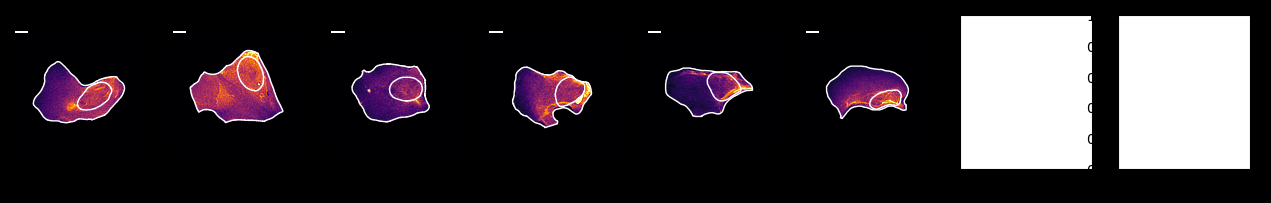

In [76]:
from scipy.ndimage import rotate, center_of_mass
from utils.helpers import get_line
from skimage import exposure

fft_shift_path = f"{project_dir}/fftcoefs/{cfg.ALIGNMENT}/shift_error_meta_fft128.txt"
def rotate_and_pad_to_size(img, angle, final_size=(600, 600), cval=0):
    rotated = rotate(img, angle=angle, reshape=True, order=1, mode='constant', cval=cval)
    h, w = rotated.shape
    target_h, target_w = final_size

    # Pad if smaller
    pad_h = max(target_h - h, 0)
    pad_w = max(target_w - w, 0)
    rotated = np.pad(rotated,
        ((pad_h // 2, pad_h - pad_h // 2),
         (pad_w // 2, pad_w - pad_w // 2)),
        mode='constant', constant_values=cval)
    
    # Crop center if larger
    center_y, center_x = rotated.shape[0] // 2, rotated.shape[1] // 2
    final = rotated[
        center_y - target_h // 2 : center_y + target_h // 2,
        center_x - target_w // 2 : center_x + target_w // 2
    ]
    return final


def rotation_and_align(image_path, shape_path, find_pattern, rescale=False, output_size=(600, 600)):
    """Rotate and align the image based on the shift dictionary, return fixed-size outputs."""

    fft_coefs = get_line(fft_shift_path, search_text=find_pattern, mode="first")
    vals = fft_coefs.strip().split(";") 
    theta = float(vals[1])
    print(find_pattern, fft_coefs, fft_shift_path, vals, theta)

    img = plt.imread(image_path)
    if rescale:
        l, h = np.percentile(img, (0, 100))
        img = exposure.rescale_intensity(img, in_range=(l, h))

    protein_ch = rotate_and_pad_to_size(img, angle=theta, final_size=output_size)
    data = np.load(shape_path)
    nuclei = rotate_and_pad_to_size(data[1, :, :], angle=theta, final_size=output_size)
    cell = rotate_and_pad_to_size(data[0, :, :], angle=theta, final_size=output_size)

    center_cell = center_of_mass(cell)
    center_nuclei = center_of_mass(nuclei)

    if center_cell[1] > center_nuclei[1]:  # rotate 180 if flipped
        protein_ch = rotate_and_pad_to_size(protein_ch.copy(), angle=180, final_size=output_size)
        cell = rotate_and_pad_to_size(cell.copy(), angle=180, final_size=output_size)
        nuclei = rotate_and_pad_to_size(nuclei.copy(), angle=180, final_size=output_size)

    return protein_ch, nuclei, cell


pixel_size = 0.1625  # μm/pixel
scale_bar_length_um = 10  # desired length in μm
scale_bar_pixels = int(scale_bar_length_um / pixel_size)
from matplotlib.patches import Rectangle

genename = 'NKTR'
b0_cells = tmp[(tmp.Gene_name == genename) & (tmp.group.isin(['b0']))].filename.unique()
b2_cells = tmp[(tmp.Gene_name == genename) & (tmp.group.isin(['b2']))].filename.unique()

images = [imread(f.replace('.npy','_protein.png')) for f in list(b0_cells) + list(b2_cells)]
global_max = max(np.percentile(img, 99) for img in images) #* 0.9

fig, ax = plt.subplots(1, 8, figsize=(2*8, 2))
fig.patch.set_facecolor('black')

for i in range(6):
    try:
        #imglist = b0_cells[[0,2,4,5,3,5]]
        imglist = b2_cells #[[2,6,7,8,9]]
        imgpath = imglist[i]
        ab, sampleid = imgpath.replace('/data/2Dshapespace/S-BIAD34/cell_masks/', '').split('/')
        rotated_img, nuclei_mask, cell_mask = rotation_and_align(image_path=imgpath.replace('/scratch/users/tle1302','/data').replace('.npy', '_protein.png'),
                        shape_path=imgpath.replace('/scratch/users/tle1302','/data'),
                        find_pattern=f"{ab}/{sampleid}")
        #ax[0, i].imshow(img, origin='lower', cmap='inferno', vmax=np.percentile(img, 99))
        #ax[0, i].axis('off') 
        ax[i].imshow(rotated_img, origin='lower', cmap='inferno', vmin=0, vmax=global_max*0.6/65535)
        ax[i].contour(cell_mask > 0, colors='white', linewidths=1, alpha=1)
        ax[i].contour(nuclei_mask > 0, colors='white', linewidths=1, alpha=1)
        ax[i].axis('off')
            
        # Draw white rectangle scale bar in bottom left corner
        scale_bar = Rectangle(
            (20, rotated_img.shape[0] - 30),  # x, y: start near bottom-left
            width=scale_bar_pixels,  # 10 µm in pixel units
            height=6,
            linewidth=0,
            edgecolor=None,
            facecolor='white'
        )
        ax[i].add_patch(scale_bar)
        
        # Draw white rectangle scale bar in bottom left corner
        scale_bar = Rectangle(
            (20, rotated_img.shape[0] - 30),  # x, y: start near bottom-left
            width=scale_bar_pixels,  # 10 µm in pixel units
            height=6,
            linewidth=0,
            edgecolor=None,
            facecolor='white'
        )
        ax[i].add_patch(scale_bar)
    except:
        print(f"Cluster {i} not found")
        #ax[1,i].imshow(np.zeros((128,128)), vmin=10, vmax=20)
        ax[i].axis('off')
    plt.savefig(f'/home/trangle/2D_shapespace/notebooks/figs/fig5E_{genename}_b2.png', dpi=300, bbox_inches='tight')

In [55]:
imglist

array(['/data/2Dshapespace/S-BIAD34/cell_masks/HPA027019/5977_E03_s1_59.npy',
       '/data/2Dshapespace/S-BIAD34/cell_masks/HPA027019/5977_E03_s3_36.npy',
       '/data/2Dshapespace/S-BIAD34/cell_masks/HPA027019/5977_E03_s2_9.npy',
       '/data/2Dshapespace/S-BIAD34/cell_masks/HPA027019/5977_E03_s2_74.npy',
       '/data/2Dshapespace/S-BIAD34/cell_masks/HPA027019/5977_E03_s2_83.npy'],
      dtype=object)

/tmp/ipykernel_445884/2959205407.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/trangle/miniconda3/envs/shapespace/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need

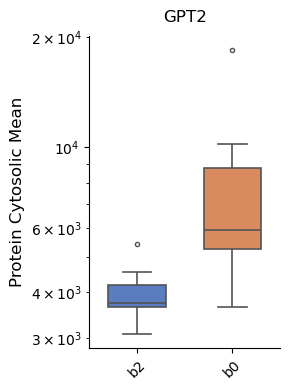

In [ ]:
#tmp[(tmp.group != 'b1') & (tmp.Gene_name == 'GAPDH')][['group', 'Protein_nu_mean']].drop_duplicates().boxplot(by='group', column='Protein_nu_mean', grid=False, rot=45, fontsize=12, figsize=(2, 2))
#plt.yscale('log')

# Set figure size
plt.figure(figsize=(3, 4))  # Adjust size for better visibility

protein = 'GPT2'
region = 'Protein_cyt_mean'
# Create a boxplot with enhanced styling
sns.boxplot(
    data=tmp[(tmp.group != 'b1') & (tmp.Gene_name == protein)][['group', region]].drop_duplicates(), 
    x='group', 
    y=region, 
    palette='muted',  # Use a visually pleasing color palette
    linewidth=1.2,  # Increase line thickness for better visibility
    width=0.6,  # Control box width
    fliersize=3  # Reduce size of outliers
)

# Apply log scale to the y-axis
plt.yscale('log')

# Improve axis labels and formatting
plt.xlabel("")  # Remove x-axis label for clean look
plt.ylabel("Protein Cytosolic Mean", fontsize=12)
plt.xticks(rotation=45, fontsize=10)  # Rotate x-axis labels for readability
plt.yticks(fontsize=10)
plt.title(protein, fontsize=12, pad=10)

# Remove grid for a cleaner look
sns.despine()  # Remove top and right borders

# Show the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [ ]:
#df[df.index=='/data/2Dshapespace/S-BIAD34/cell_masks/HPA030550/6736_D10_s4_12.npy'].mean().values
fft_shift_path

'/data/2Dshapespace/B2AI/fftcoefs/fft_cell_major_axis_polarized/shift_error_meta_fft128.txt'

In [ ]:
from scipy.stats import wasserstein_distance
wasserstein_distance(tmp.Protein_cell_mean, tmp.Protein_nu_mean)

3617.894203613059